# Template Matching

In [108]:
import numpy as np
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd

Importing the first frame

In [109]:
# --- Paths ---
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / "recording_2" / "Recording_2.mp4")
CSV_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "lane_lines" / "definitive_lines_2.csv")

# --- Load frame ---
frame_index = 30
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Failed to read the frame")

height, width = frame.shape[:2]
df = pd.read_csv(CSV_POSITIONS_FILE_PATH)
frame_data = df.iloc[frame_index]

Importing the template

In [110]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

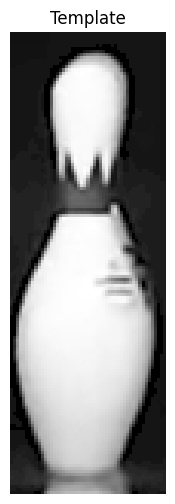

In [111]:
template = cv2.imread('intermediate_data/Template_pin_3.png', 0) # 0 for the grayscale image

h, w = template.shape

showImage(template, "Template")

Changing the first frame in order to delete the parts that are off the main lane

In [112]:
# --- Helper functions ---
def get_extended_line(x1, y1, x2, y2, img_width, img_height):
    """Extend a line to the image boundaries."""
    if x1 == x2:
        return (x1, 0), (x2, img_height)
    
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    points = []

    y_left = int(m * 0 + b)
    y_right = int(m * img_width + b)
    if 0 <= y_left <= img_height:
        points.append((0, y_left))
    if 0 <= y_right <= img_height:
        points.append((img_width, y_right))

    if m != 0:
        x_top = int((0 - b) / m)
        x_bottom = int((img_height - b) / m)
        if 0 <= x_top <= img_width:
            points.append((x_top, 0))
        if 0 <= x_bottom <= img_width:
            points.append((x_bottom, img_height))

    return points[:2] if len(points) >= 2 else ((x1, y1), (x2, y2))

In [113]:
def get_intersection(p1, p2, p3, p4):
    """Find the intersection point of two lines."""
    xdiff = (p1[0] - p2[0], p3[0] - p4[0])
    ydiff = (p1[1] - p2[1], p3[1] - p4[1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(p1, p2), det(p3, p4))
    x = int(det(d, xdiff) / div)
    y = int(det(d, ydiff) / div)
    return x, y

In [114]:
# --- Extract line endpoints ---
hx1, hy1, hx2, hy2 = map(int, [frame_data['hx1'], frame_data['hy1'], frame_data['hx2'], frame_data['hy2']])
lx1, ly1, lx2, ly2 = map(int, [frame_data['lx1'], frame_data['ly1'], frame_data['lx2'], frame_data['ly2']])
rx1, ry1, rx2, ry2 = map(int, [frame_data['rx1'], frame_data['ry1'], frame_data['rx2'], frame_data['ry2']])

# --- Get extended lines ---
h_pt1, h_pt2 = get_extended_line(hx1, hy1, hx2, hy2, width, height)
l_pt1, l_pt2 = get_extended_line(lx1, ly1, lx2, ly2, width, height)
r_pt1, r_pt2 = get_extended_line(rx1, ry1, rx2, ry2, width, height)

# --- Get triangle intersection points ---
int1 = get_intersection(h_pt1, h_pt2, l_pt1, l_pt2)
int2 = get_intersection(h_pt1, h_pt2, r_pt1, r_pt2)
int3 = get_intersection(l_pt1, l_pt2, r_pt1, r_pt2)

if None in [int1, int2, int3]:
    raise ValueError("Could not find all three triangle points")

triangle = np.array([int1, int2, int3])

# --- Create mask and apply it ---
mask = np.zeros((height, width), dtype=np.uint8)
cv2.drawContours(mask, [triangle], 0, 255, -1)

masked_frame = cv2.bitwise_and(frame, frame, mask=mask)

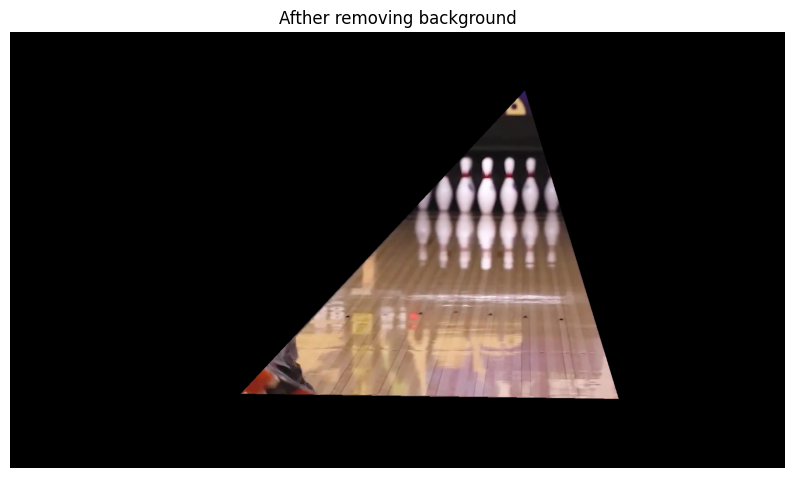

In [115]:
showImage(masked_frame, "Afther removing background")

Now I want to resize the template in the best way possible

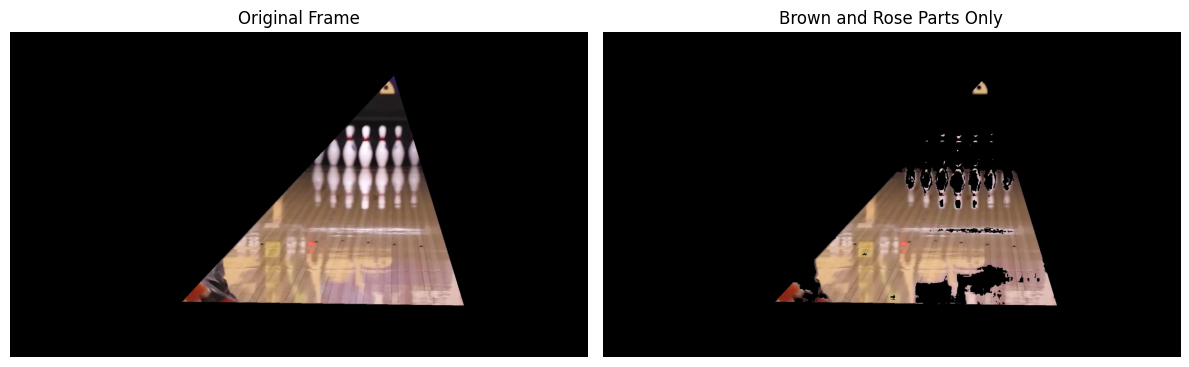

In [116]:
# Convert frame to HSV color space
hsv = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2HSV)

# Brown range
lower_brown = np.array([00, 00, 50])
upper_brown = np.array([20, 255, 255])

'''
Hue -> Covers reddish to yellowish-brown tones
Saturation -> Filters out grays
Value -> Keeps medium to bright pixels, avoids too-dark shadows
'''

# Rose (pinkish-red) 
lower_rose = np.array([150, 30, 200])
upper_rose = np.array([180, 200, 255])

'''
Hue -> Covers magenta, pink, and rose hues
Saturation -> Avoids overly dull or overly neon colors
Value -> Captures only the bright parts
'''

# Create masks
mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
mask_rose = cv2.inRange(hsv, lower_rose, upper_rose)

# Combine both masks
combined_mask = cv2.bitwise_or(mask_brown, mask_rose)

# Apply the combined mask to the original frame
brown_and_rose = cv2.bitwise_and(frame, frame, mask=combined_mask)

# Display
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Frame")
plt.imshow(cv2.cvtColor(masked_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Brown and Rose Parts Only")
plt.imshow(cv2.cvtColor(brown_and_rose, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

Stopped at row 452 with 1.72% non-black pixels


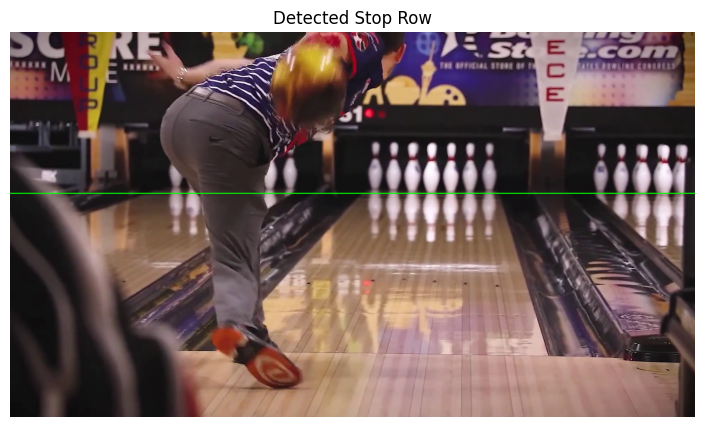

In [117]:
# Threshold for black (treat anything darker than this as black)
black_thresh = 30

# Convert masked image to grayscale for easier intensity check
gray_masked = cv2.cvtColor(brown_and_rose, cv2.COLOR_BGR2GRAY)

# Start from row y = 100
start_y = int1[1]
height = gray_masked.shape[0]
stop_row = None

for y in range(start_y, -1, -1):  # go from int1 down to 0
    row = gray_masked[y, :]
    non_black_pixels = np.count_nonzero(row > black_thresh)
    percentage_non_black = (non_black_pixels / len(row)) * 100

    if percentage_non_black < 2:
        stop_row = y
        print(f"Stopped at row {y} with {percentage_non_black:.2f}% non-black pixels")
        break

if stop_row is None:
    print("No row found with <2% non-black pixels after y=100.")
else:
    # Optional: visualize the stopping row on the image
    annotated = frame.copy()
    cv2.line(annotated, (0, stop_row), (annotated.shape[1], stop_row), (0, 255, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.title("Detected Stop Row")
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

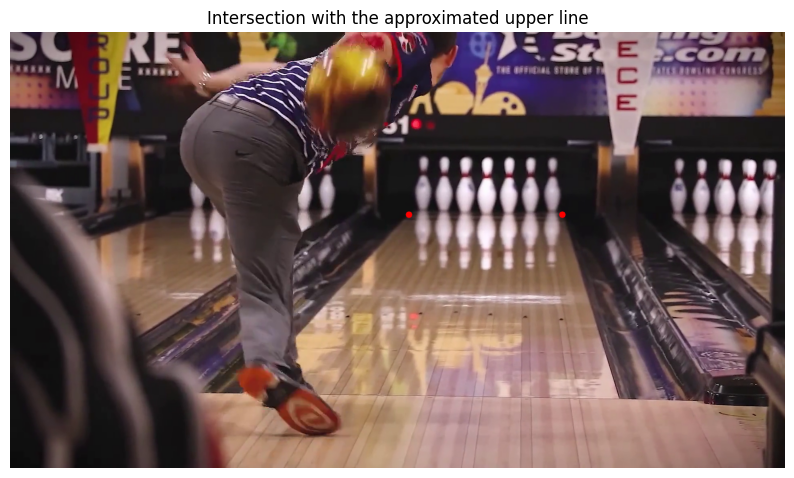

In [118]:
# --- Define the horizontal line y = 450 ---
y_horizontal = y
horizontal_line_p1 = (0, y_horizontal)
horizontal_line_p2 = (width, y_horizontal)

# --- Calculate intersections with the horizontal line ---
intersection_l = get_intersection(l_pt1, l_pt2, horizontal_line_p1, horizontal_line_p2)
intersection_r = get_intersection(r_pt1, r_pt2, horizontal_line_p1, horizontal_line_p2)

if intersection_l is None or intersection_r is None:
    raise ValueError("Could not find intersection with horizontal line")

# --- Draw the intersection points on the frame ---
frame_with_points = frame.copy()
cv2.circle(frame_with_points, intersection_l, 8, (0, 0, 255), -1)
cv2.circle(frame_with_points, intersection_r, 8, (0, 0, 255), -1)

# Show the result
showImage(frame_with_points, "Intersection with the approximated upper line")

In [119]:
# --- Calculate the distance between the two intersection points ---
def euclidean_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

distance = euclidean_distance(intersection_l, intersection_r)
print(f"Distance between the two intersection points: {distance:.2f} pixels")

Distance between the two intersection points: 380.00 pixels


In [120]:
lane_width = 1066
pin_height_real = 381 + 40 # 20 is the margin taken from the template
pin_height_template = h
pin_width_template = w

pin_height = (pin_height_real * distance) / lane_width
f = pin_height / pin_height_template

template = cv2.resize(template, (0, 0), fx=f, fy=f)

print("Original template size:", w, h)
print("Scaling factors -> fx:", f, "fy:", f)

new_w = int(pin_width_template * f)
new_h = int(pin_height_template * f)

print("New template size:", new_w, new_h)

Original template size: 51 152
Scaling factors -> fx: 0.9873358348968105 fy: 0.9873358348968105
New template size: 50 150


Applying the Template Matching methods

Coordinates of the bottom right location: (1207, 453)


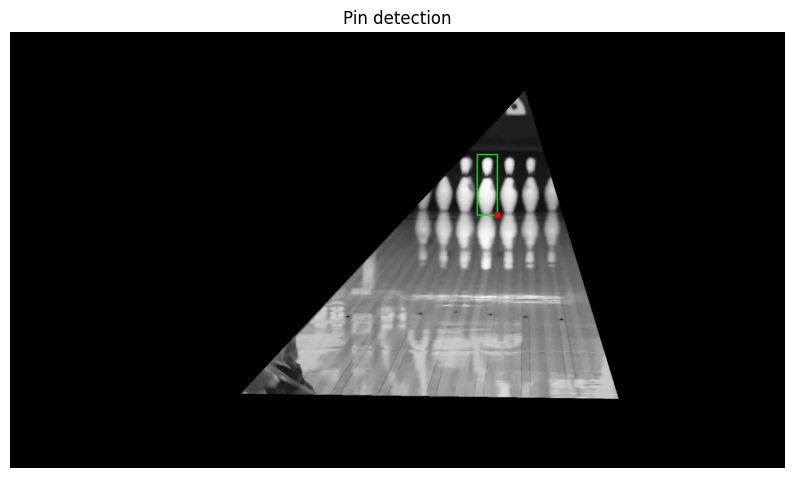

In [121]:
masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)

# Method for doing Template Matching
method = cv2.TM_CCOEFF

img = masked_frame.copy()
result = cv2.matchTemplate(img, template, method) # This performs Convolution, the output will be (Width - w + 1, Height - h + 1)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result) # This returns min, max values, min, max locations
location = max_loc
    
bottom_right = (location[0] + new_w, location[1] + new_h)
print(f"Coordinates of the bottom right location:", bottom_right)

img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.rectangle(img, location, bottom_right, color=(0,255,0), thickness=2)
cv2.circle(img, bottom_right, 8, (0, 0, 255), -1)

showImage(img, "Pin detection")

Now I have to extract the line from the pin detection and then think about the gradient of that line

I draw the line passing through the point

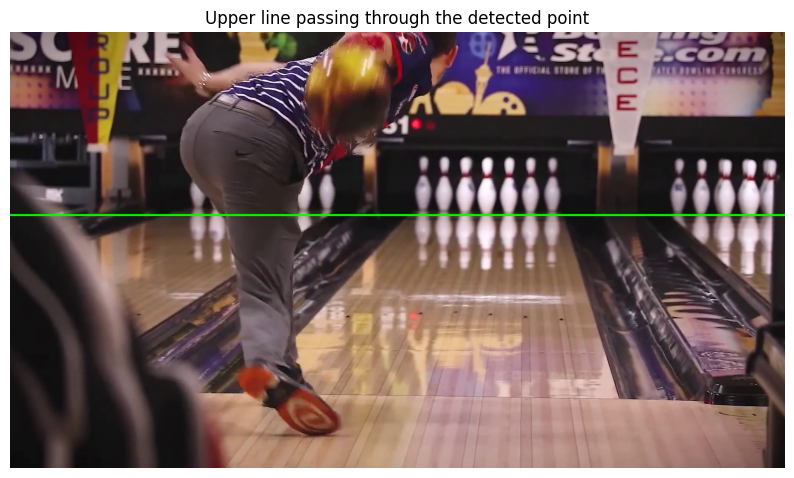

In [122]:
annotated = frame.copy()
cv2.line(annotated, (0, bottom_right[1]), (annotated.shape[1], bottom_right[1]), (0, 255, 0), 3)

showImage(annotated, "Upper line passing through the detected point")

I tilt the line according to a ratio between the base angles 

In [123]:
# Compute the slope (gradient) of the horizontal line
if hx2 != hx1:
    slope_h = (hy2 - hy1) / (hx2 - hx1)
    print(f"Slope (gradient) of the horizontal line: {slope_h:.6f}")
else:
    print("Horizontal line is vertical — undefined slope")

Slope (gradient) of the horizontal line: 0.013514


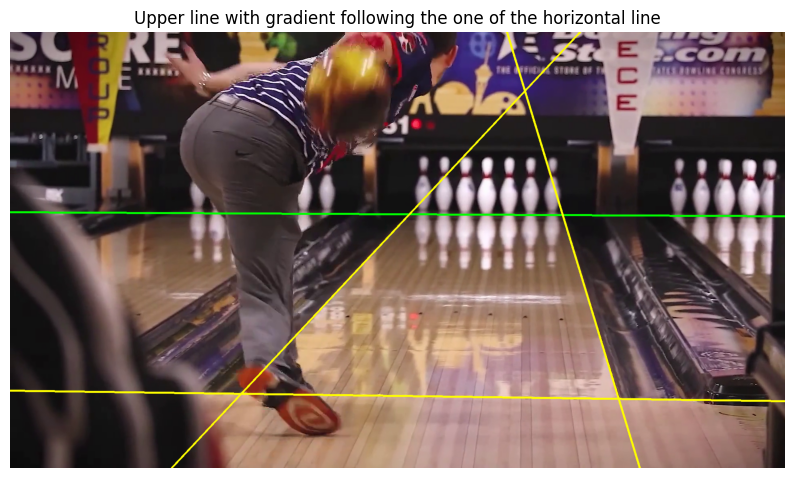

In [124]:
# Lenght between the detected point and the point I want to create
length = 100 

# Calculate two points along the line
ux1 = int(bottom_right[0] - length)
uy1 = int(bottom_right[1] - slope_h/2 * length) # TODO: change the /2 because it is wrong
ux2 = int(bottom_right[0] + length)
uy2 = int(bottom_right[1] + slope_h/2 * length) # TODO: change the /2 because it is wrong

# Calculate the extended line points
u_pt1, u_pt2 = get_extended_line(ux1, uy1, ux2, uy2, width, height)

# Upper, horizontal, left and right lines
annotated = frame.copy()
cv2.line(annotated, u_pt1, u_pt2, (0, 255, 0), 3)
cv2.line(annotated, h_pt1, h_pt2, (0, 255, 255), 3)
cv2.line(annotated, l_pt1, l_pt2, (0, 255, 255), 3)
cv2.line(annotated, r_pt1, r_pt2, (0, 255, 255), 3)

showImage(annotated, "Upper line with gradient following the one of the horizontal line")

PROBLEM: I can calculate the gradient of the upper line only if I have the calibration of the camera

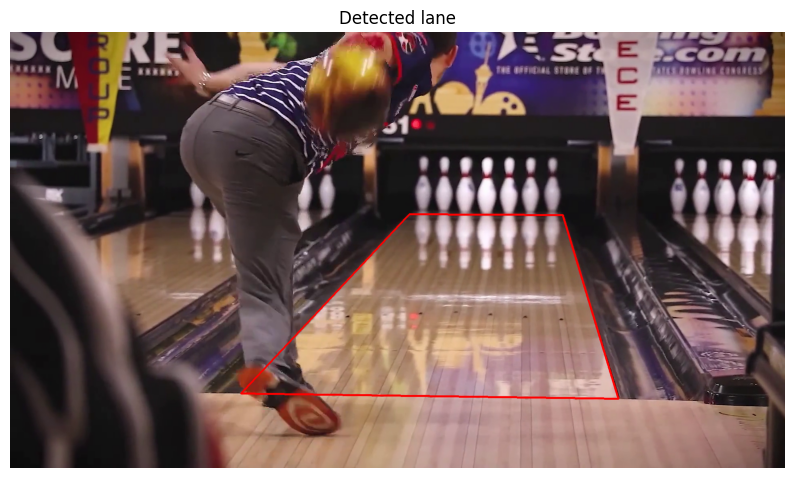

In [125]:
int4 = get_intersection(u_pt1, u_pt2, l_pt1, l_pt2)
int5 = get_intersection(u_pt1, u_pt2, r_pt1, r_pt2)

annotated = frame.copy()
cv2.line(annotated, int1, int2, (0, 0, 255), 3)
cv2.line(annotated, int2, int5, (0, 0, 255), 3)
cv2.line(annotated, int5, int4, (0, 0, 255), 3)
cv2.line(annotated, int4, int1, (0, 0, 255), 3)

showImage(annotated, "Detected lane")

Here we need some of post processing for the upper line and also for the entire lane taken as a unit shape.